In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [4]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [5]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [6]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412623,2013,1,regular,True,False,3878.0,2623,Missouri State,MVFC,fcs,17.0,NaN,2466,Northwestern State,Southland,fcs,23.0,NaN
4,332412230,2013,1,regular,True,True,3681.0,2230,Fordham,Patriot,fcs,51.0,NaN,227,Rhode Island,CAA,fcs,26.0,NaN


In [7]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [8]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [ ]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data


Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [10]:
fg_events = [c for c in df_drives.drive_result.unique() if 'FG' in c]
print(fg_events)
df_drives = df_drives[df_drives.drive_result.isin(fg_events)].reset_index(drop=True)

['FG GOOD', 'FG MISSED', 'FG MISSED TD', 'MISSED FG', 'FG', 'FG TD', 'MISSED FG TD', 'BLOCKED FG']


In [11]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Join and Filter the Data

In [12]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number',
       'end_yards_to_goal', 'drive_result',
       'is_home_offense', 'start_offense_score', 'end_offense_score', 'start_defense_score',
       'end_defense_score', 
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']
elo_cols = ['season', 'week', 'team_id', 'elo']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    ).merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)

In [13]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,end_yards_to_goal,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230908,8.0,3.0,FG GOOD,False,0.0,3.0,7.0,7.0,2.0,2.0,55.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230916,16.0,22.0,FG GOOD,True,7.0,10.0,10.0,10.0,4.0,10.0,57.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
2,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257903,3.0,28.0,FG GOOD,True,7.0,10.0,0.0,0.0,1.0,4.0,53.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.54548645,True,3035.188373,2475.527442
3,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257910,10.0,41.0,FG GOOD,True,17.0,20.0,7.0,7.0,2.0,1.0,32.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.54548645,True,3035.188373,2475.527442
4,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,North Carolina,South Carolina,33241257912,12.0,48.0,FG GOOD,False,0.0,10.0,0.0,20.0,3.0,7.0,51.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.54548645,True,3035.188373,2475.527442


In [14]:
df.drive_result.value_counts()

drive_result
FG              23963
MISSED FG        8450
FG GOOD          1771
FG MISSED         677
MISSED FG TD       59
BLOCKED FG         10
FG TD               7
FG MISSED TD        4
Name: count, dtype: int64

In [15]:
df.isna().sum()

game_id                    0
season                     0
week                       0
season_type                0
completed                  0
neutral_site               0
venue_id                 134
home_id                    0
home_team                  0
home_conference           17
home_division             17
away_id                    0
away_team                  0
away_conference          107
away_division            107
offense                    0
defense                    0
drive_id                   0
drive_number               0
end_yards_to_goal          0
drive_result               0
is_home_offense            0
start_offense_score        0
end_offense_score          0
start_defense_score        0
end_defense_score          0
end_period                 0
end_time_minutes           0
end_time_seconds           0
game_indoors             783
temperature              783
dew_point                783
humidity                 783
precipitation            783
snowfall      

## 3. Feature Engineering

In [16]:
df = df.assign(
    pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    score_diff = df['start_offense_score'] - df['start_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    off_pts_scored = df.end_offense_score - df.start_offense_score,
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    fg_team_pregame_elo = np.where(df.offense == df.home_team, df.home_pregame_elo, df.away_pregame_elo),
)

df['pressure_rating'] = np.select(
    [
        (df['pct_game_played'] >= (58 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 2 min
        (df['pct_game_played'] >= (55 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 5 - 2 min
        (df['pct_game_played'] >= (50 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 10 - 5 min
        (df['pct_game_played'] >= (45 / 60)) & (df['score_diff'] >= -3) & (df['score_diff'] <= 0),  # tie or take the lead, last 15 - 10 min
    ],
    [4, 3, 2, 1],
    default=0
)

df['elevation'] = df['elevation'].astype(float)

df['fg_made'] = np.where(df.off_pts_scored == 3, 1, 0)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_46730/2743034139.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_46730/2743034139.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


In [17]:
df.pressure_rating.value_counts()

pressure_rating
0    32879
4     1118
1      373
2      352
3      219
Name: count, dtype: int64

In [18]:
# Filter out overtime plays
df = df.query('0 < end_period <= 4')

# Game must be completed
df = df.query('completed == True')

# Filter out FG attempts where offense scored other than 0 or 3 points
df = df.query('off_pts_scored.isin([0,3])')

df.rename(columns={'end_yards_to_goal': 'fg_distance'}, inplace=True)

# Assuming any FG attempts over 60 yards is an erroneous datapoint
df = df.query('fg_distance <= 60').reset_index(drop=True)

df = df.query('0 <= pct_game_played <= 1')

df.reset_index(drop=True, inplace=True)

In [19]:
df[['fg_made','drive_result']].value_counts()

fg_made  drive_result
1        FG              22679
0        MISSED FG        8126
1        FG GOOD          1662
0        FG MISSED         653
         FG                372
         MISSED FG TD       56
         FG GOOD            21
         BLOCKED FG         10
1        FG TD               4
0        FG MISSED TD        3
         FG TD               2
1        MISSED FG           2
Name: count, dtype: int64

## 4. Final Data

In [20]:
# at least one team in fbs
df = df.query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_team_pregame_elo,pressure_rating,fg_made
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230908,8.0,3.0,FG GOOD,False,0.0,3.0,7.0,7.0,2.0,2.0,55.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.451389,-7.0,-1,fcs,fbs,3.0,1553.191164,0,1
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230916,16.0,22.0,FG GOOD,True,7.0,10.0,10.0,10.0,4.0,10.0,57.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.817500,-3.0,1,fbs,fcs,3.0,1954.443118,1,1
2,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257903,3.0,28.0,FG GOOD,True,7.0,10.0,0.0,0.0,1.0,4.0,53.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.545486,True,3035.188373,2475.527442,0.168611,7.0,1,fbs,fbs,3.0,3035.188373,0,1
3,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257910,10.0,41.0,FG GOOD,True,17.0,20.0,7.0,7.0,2.0,1.0,32.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.545486,True,3035.188373,2475.527442,0.474444,10.0,1,fbs,fbs,3.0,3035.188373,0,1
4,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,33241015403,3.0,33.0,FG MISSED,True,0.0,0.0,7.0,7.0,1.0,9.0,5.0,False,84.0,69.1,61.0,0.0,0.0,13.9,1013.2,None,283.548584,False,1961.923659,804.297475,0.098611,-7.0,1,fbs,fcs,0.0,1961.923659,0,0


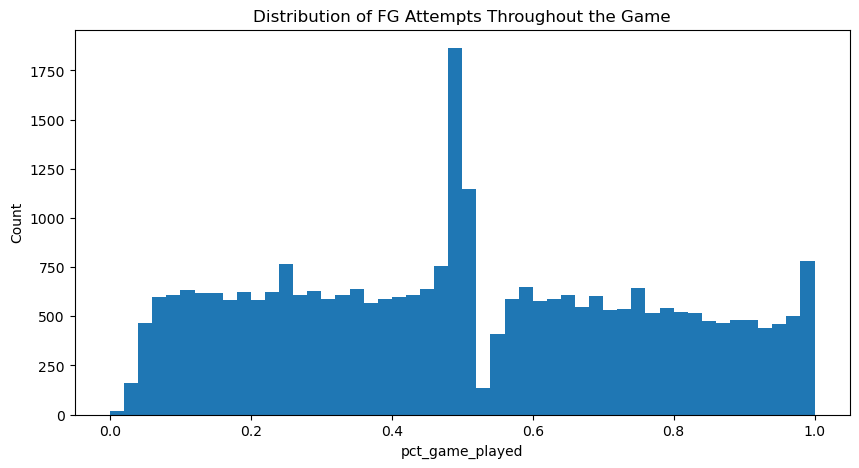

In [21]:
# plot a hist plot of pct_game_played
plt.figure(figsize=(10, 5))
plt.hist(df.pct_game_played, bins=50)
plt.title('Distribution of FG Attempts Throughout the Game')
plt.xlabel('pct_game_played')
plt.ylabel('Count')
plt.show()

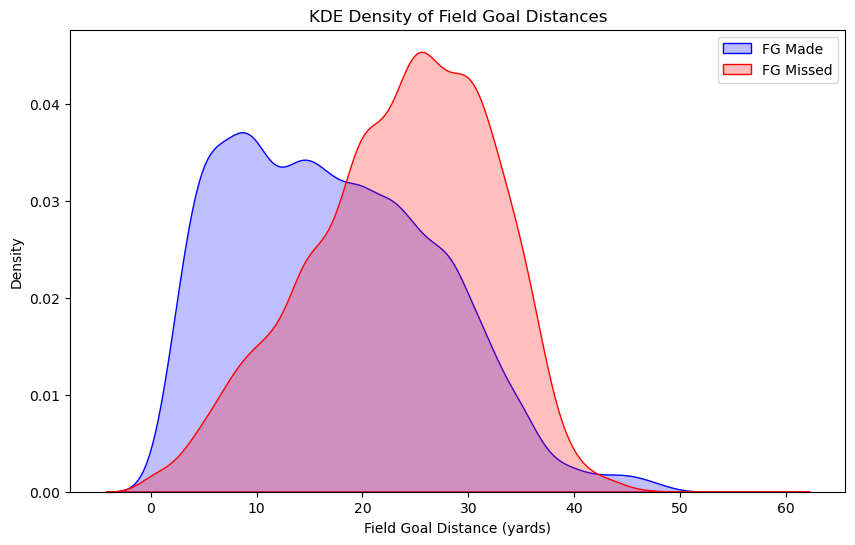

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('fg_made==1').fg_distance, fill=True, color='blue', label='FG Made')
sns.kdeplot(df.query('fg_made==0').fg_distance, fill=True, color='red', label='FG Missed')
plt.title('KDE Density of Field Goal Distances')
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Density')
plt.legend()
plt.show()

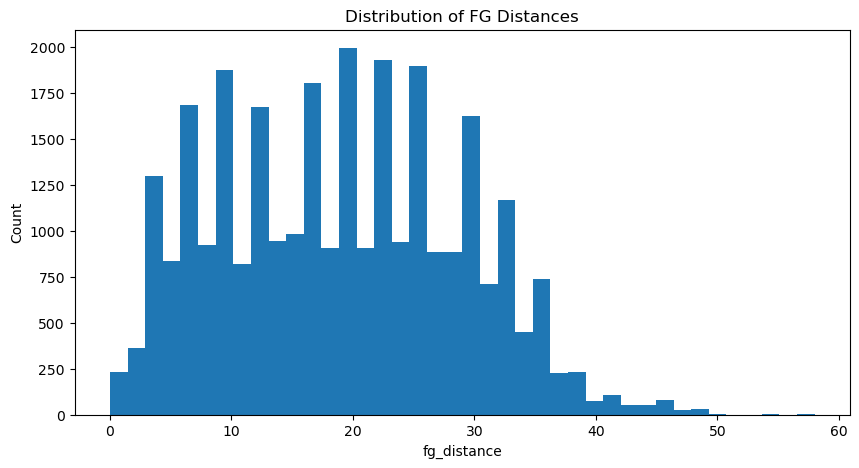

In [23]:
# plot a hist plot of fg_distance
plt.figure(figsize=(10, 5))
plt.hist(df.fg_distance, bins=40)
plt.title('Distribution of FG Distances')
plt.xlabel('fg_distance')
plt.ylabel('Count')
plt.show()

In [24]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,start_defense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_team_pregame_elo,pressure_rating,fg_made
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230908,8.0,3.0,FG GOOD,False,0.0,3.0,7.0,7.0,2.0,2.0,55.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.451389,-7.0,-1,fcs,fbs,3.0,1553.191164,0,1
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230916,16.0,22.0,FG GOOD,True,7.0,10.0,10.0,10.0,4.0,10.0,57.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.817500,-3.0,1,fbs,fcs,3.0,1954.443118,1,1
2,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257903,3.0,28.0,FG GOOD,True,7.0,10.0,0.0,0.0,1.0,4.0,53.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.545486,True,3035.188373,2475.527442,0.168611,7.0,1,fbs,fbs,3.0,3035.188373,0,1
3,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,153,North Carolina,ACC,fbs,South Carolina,North Carolina,33241257910,10.0,41.0,FG GOOD,True,17.0,20.0,7.0,7.0,2.0,1.0,32.0,False,93.9,71.8,49.0,0.0,0.0,0.0,1011.7,None,60.545486,True,3035.188373,2475.527442,0.474444,10.0,1,fbs,fbs,3.0,3035.188373,0,1
4,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,2506,Presbyterian,Big South,fcs,Wake Forest,Presbyterian,33241015403,3.0,33.0,FG MISSED,True,0.0,0.0,7.0,7.0,1.0,9.0,5.0,False,84.0,69.1,61.0,0.0,0.0,13.9,1013.2,None,283.548584,False,1961.923659,804.297475,0.098611,-7.0,1,fbs,fcs,0.0,1961.923659,0,0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_46730/3637822262.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


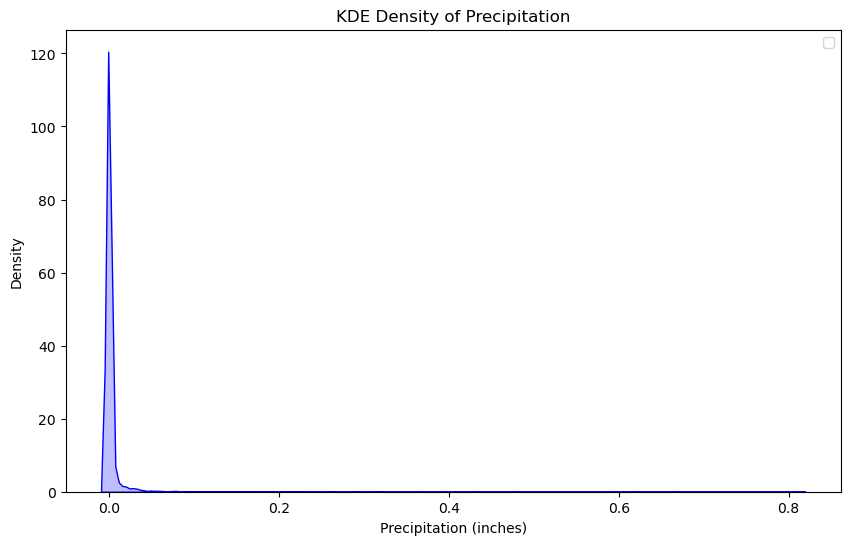

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.precipitation, fill=True, color='blue')
plt.title('KDE Density of Precipitation')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_46730/2083828262.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


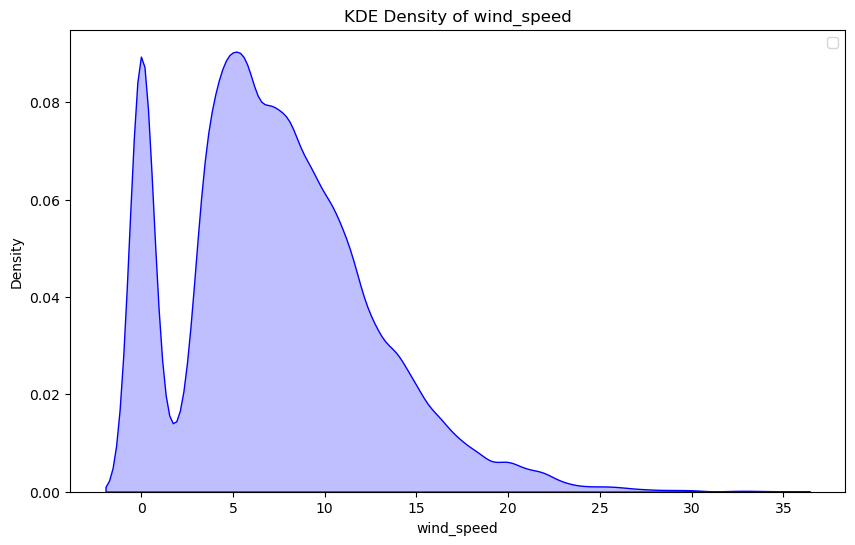

In [26]:
feature = 'wind_speed'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_46730/829338877.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


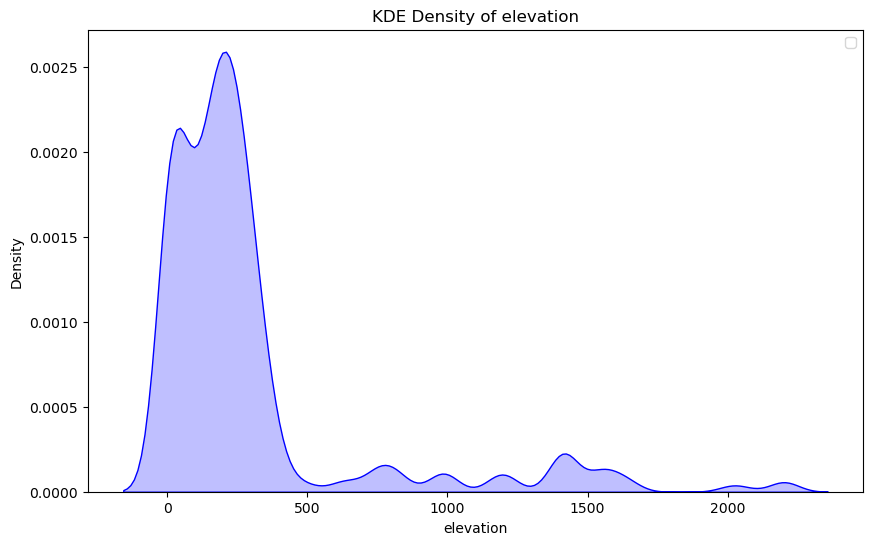

In [27]:
feature = 'elevation'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

## 5. Make the model

In [ ]:
data = df[['game_id', 'fg_distance', 'pressure_rating', 'is_home_team', 
           'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
           'fg_team_pregame_elo', 'fg_made'
          ]]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)]

In [29]:
data.head()

,game_id,fg_distance,pressure_rating,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,fg_team_pregame_elo,fg_made
0,332412309,3.0,0,-1,False,321.364166,3.4,0.0,82.0,False,1553.191164,1
1,332412309,22.0,1,1,False,321.364166,3.4,0.0,82.0,False,1954.443118,1
2,332412579,28.0,0,1,True,60.545486,0.0,0.0,93.9,False,3035.188373,1
3,332412579,41.0,0,1,True,60.545486,0.0,0.0,93.9,False,3035.188373,1
4,332410154,33.0,0,1,False,283.548584,13.9,0.0,84.0,False,1961.923659,0


In [30]:
data.isna().sum()

game_id                0
fg_distance            0
pressure_rating        0
is_home_team           0
grass                  0
elevation              0
wind_speed             0
precipitation          0
temperature            0
game_indoors           0
fg_team_pregame_elo    0
fg_made                0
dtype: int64

In [31]:
data_train.game_id.nunique()

7768

In [32]:
df.fg_made.value_counts()

fg_made
1    21547
0     7789
Name: count, dtype: int64

In [33]:
data_train.fg_made.value_counts(normalize=True)

fg_made
1    0.734287
0    0.265713
Name: proportion, dtype: float64

In [34]:
# bin fg distance int bins by 10 yardds, and then pring value counts
bins = np.arange(0, 61, 10)
labels = [f'{i}-{i+10}' for i in bins[:-1]]
df['fg_distance_bins'] = pd.cut(df.fg_distance, bins=bins, labels=labels, right=False)
print(df['fg_distance_bins'].value_counts().sort_index())
df.drop(columns=['fg_distance_bins'], inplace=True)

fg_distance_bins
0-10     6257
10-20    9007
20-30    9344
30-40    4307
40-50     417
50-60       4
Name: count, dtype: int64


In [35]:
model_dir = os.path.join(DATA_DIR, 'models', 'fg_probability')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()  # Create an empty Booster object
    model.load_model(model_path)  # Load the model from the json file
    models.append(model)

print(f"Loaded {len(models)} models from the '{model_dir}' folder.")

Loaded 100 models from the '../data/models/fg_probability' folder.


In [ ]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

N_BOOTSTRAP = 100
N_SAMPLE = len(data_train)
    
feature_names = data_train.drop(columns=['game_id', 'fg_made']).columns.tolist()
monotonic_constraints_map = {
    "fg_distance": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "game_indoors": 1,
    "pregame_elo_diff": 1,
    "pressure_rating": -1,
    "fg_team_pregame_elo": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.01, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

# Bootstrapping
models = []
for i in tqdm(range(N_BOOTSTRAP), desc='Bootstrapping'):
    # Bootstrap sampling
    train_data = data_train.sample(n=N_SAMPLE, replace=True, random_state=SEED)
 
    # Row-wise 80-20 split
    train, valid = train_test_split(train_data, test_size=0.2, random_state=SEED)

    train_x = train.drop(columns=['game_id', 'fg_made'])
    train_y = train['fg_made']
    valid_x = valid.drop(columns=['game_id', 'fg_made'])
    valid_y = valid['fg_made']

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(
        study_name="fg_probability_hyperopt", 
        direction="minimize", 
        load_if_exists=True
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

    # Train a model with the best params
    best_params = {
        **study.best_trial.params,
        'nthread': -1,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'logloss',
        'seed': SEED,
    }
    bst = xgb.train(
        best_params, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    models.append(bst)

Bootstrapping: 100%|██████████| 100/100 [29:38<00:00, 17.78s/it]


Calculating SHAP values: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


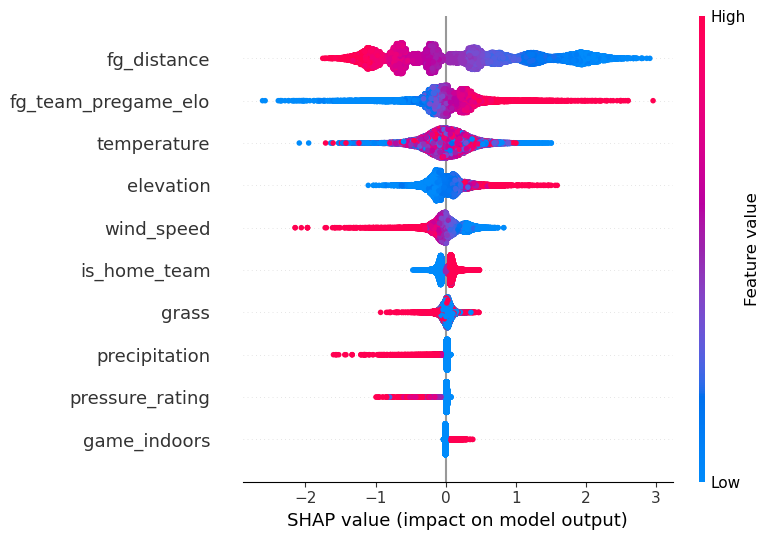

In [51]:
all_shap_values = []

background = data_train.drop(columns=['game_id', 'fg_made'])

for model in tqdm(models[:10], desc='Calculating SHAP values'):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(background)
    all_shap_values.append(shap_vals)

shap_values_array = np.stack(all_shap_values)  # shape: (n_models, n_samples, n_features)
mean_shap_values = np.mean(shap_values_array, axis=0)  # shape: (n_samples, n_features)

shap.summary_plot(mean_shap_values, background)

Calculating Feature Importance: 100%|██████████| 100/100 [00:00<00:00, 1881.11it/s]


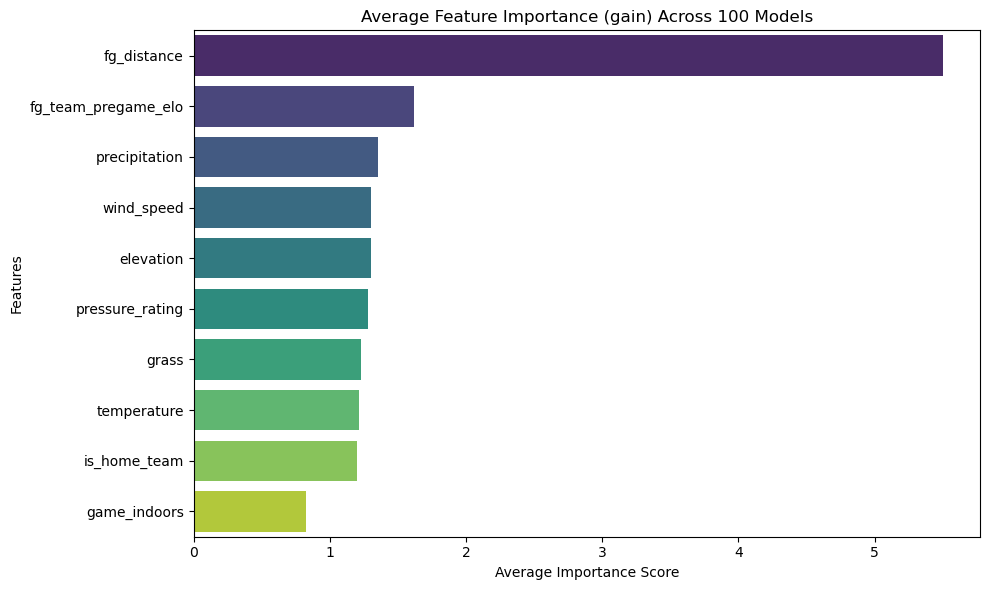

In [52]:
def plot_aggregated_feature_importance(models, importance_type="gain"):
    total_importance = {}

    # Aggregate importances across all models
    for model in tqdm(models, desc='Calculating Feature Importance'):
        importance = model.get_score(importance_type=importance_type)
        for feat, score in importance.items():
            total_importance[feat] = total_importance.get(feat, 0) + score

    # Average the importance by number of models
    for feat in total_importance:
        total_importance[feat] /= len(models)

    importance_df = pd.DataFrame({
        "Feature": list(total_importance.keys()),
        "Importance": list(total_importance.values())
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis", 
        hue="Feature", 
        dodge=False
    )
    plt.title(f"Average Feature Importance ({importance_type}) Across {len(models)} Models")
    plt.xlabel("Average Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

plot_aggregated_feature_importance(models, importance_type="gain") # gain, weight, cover

Average Test Log Loss over 100 models: 0.58444


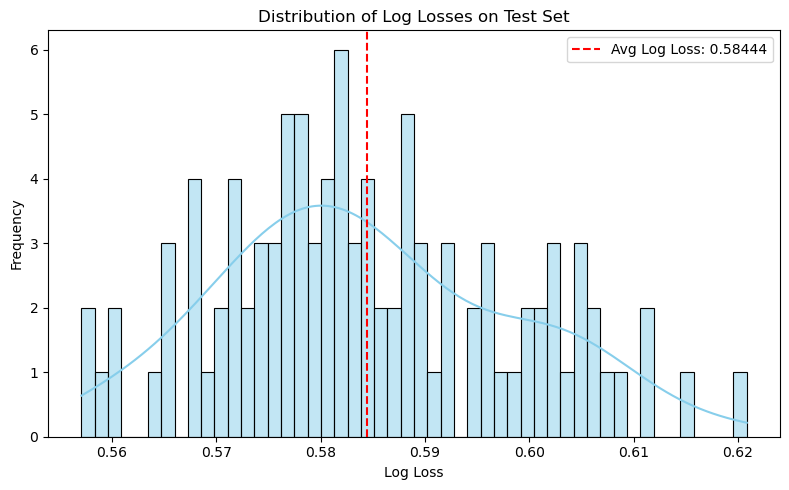

In [64]:
test_x = data_test.drop(columns=['game_id', 'fg_made'])
test_y = data_test['fg_made'].values.ravel()
dtest = xgb.DMatrix(test_x, label=test_y)


loglosses = []

for model in models:
    preds = model.predict(dtest)
    logloss = log_loss(test_y, preds)
    loglosses.append(logloss)

avg_logloss = np.mean(loglosses)
print(f"Average Test Log Loss over {len(models)} models: {avg_logloss:.5f}")

plt.figure(figsize=(8, 5))
sns.histplot(loglosses, bins=50, kde=True, color="skyblue")
plt.axvline(avg_logloss, color="red", linestyle="--", label=f"Avg Log Loss: {avg_logloss:.5f}")
plt.title("Distribution of Log Losses on Test Set")
plt.xlabel("Log Loss")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
data_all = data.drop(columns=['game_id', 'fg_made'])
dall = xgb.DMatrix(data_all)

preds_all_models = []

for model in models:
    preds = model.predict(dall)
    preds_all_models.append(preds)

preds_all_models = np.array(preds_all_models)

# Calculate the 5%, 50%, 95% percentiles and the mean for each sample
df['fg_proba_5'] = np.percentile(preds_all_models, 5, axis=0)
df['fg_proba_50'] = np.percentile(preds_all_models, 50, axis=0)
df['fg_proba_95'] = np.percentile(preds_all_models, 95, axis=0)
df['fg_proba_mean'] = np.mean(preds_all_models, axis=0)

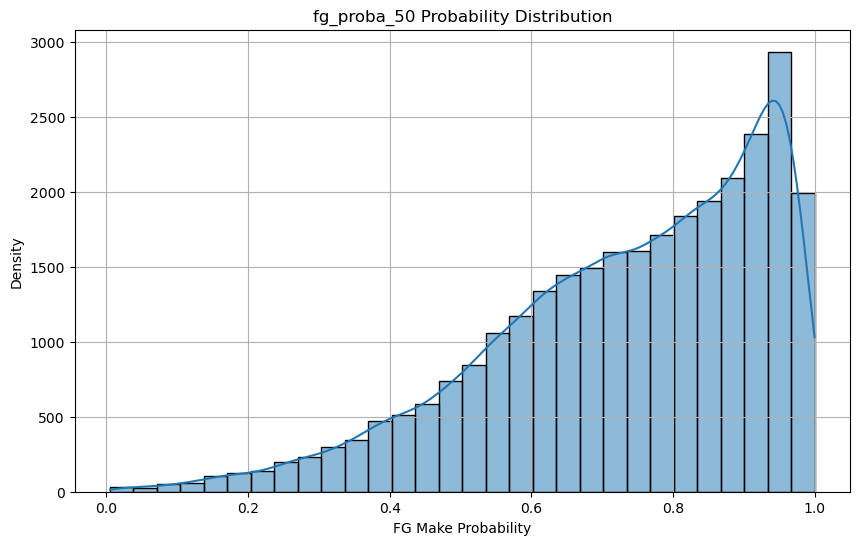

In [73]:
# plot win probability
def plot_wp(df, col='fg_proba_50'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('FG Make Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='fg_proba_50')

In [74]:
df.fg_proba_50.describe()

count    29336.000000
mean         0.734909
std          0.196266
min          0.005167
25%          0.611332
50%          0.771686
75%          0.899881
max          0.999765
Name: fg_proba_50, dtype: float64

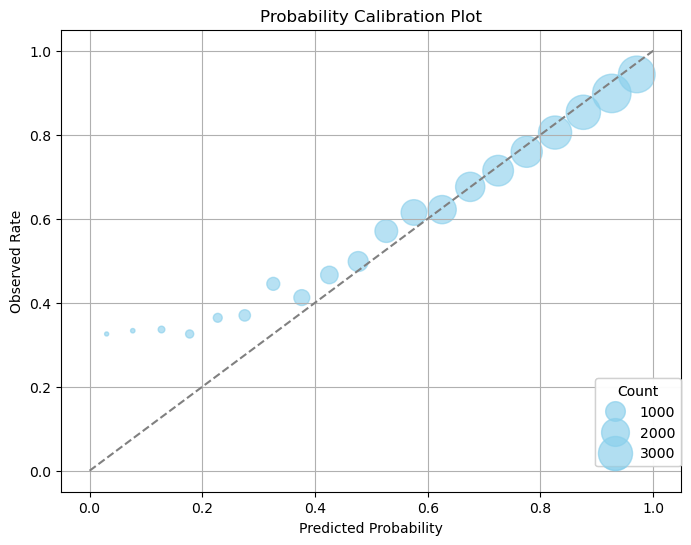

In [75]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='fg_proba_50', actual_col='fg_made', bins=20)

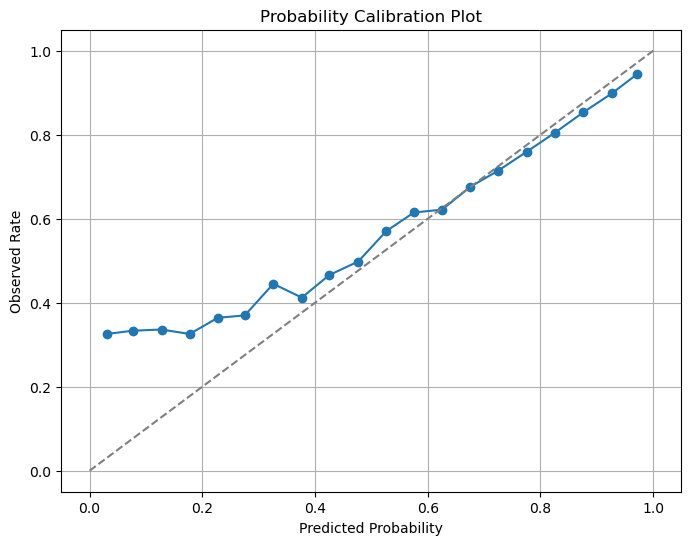

In [76]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='fg_proba_50', actual_col='fg_made', bins=20)

In [83]:
(
    df[data.columns.tolist() + ['fg_proba_5','fg_proba_50','fg_proba_95']]
    .sort_values(by='fg_distance', ascending=False)
    .head(20)
)

,game_id,fg_distance,pressure_rating,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,fg_team_pregame_elo,fg_made,fg_proba_5,fg_proba_50,fg_proba_95
2500,400547834,58.0,0,-1,True,355.096252,5.8,0.000,93.2,False,1581.604127,0,0.070453,0.137507,0.263682
334,332500326,54.0,0,1,False,177.867645,19.7,0.118,80.6,False,1414.647852,0,0.014969,0.037950,0.088994
489,332570356,50.0,0,-1,False,293.000000,0.0,0.000,66.0,False,2433.602178,1,0.593085,0.606205,0.621273
291,332500025,50.0,0,-1,False,125.310806,12.7,0.000,86.5,False,1188.300385,1,0.131267,0.211090,0.322407
1859,333270097,49.0,0,-1,False,138.561600,8.1,0.000,43.0,False,1528.854005,1,0.100527,0.181891,0.272669
1045,332850120,49.0,0,-1,False,32.687481,8.1,0.000,66.9,False,1920.329923,1,0.437221,0.467714,0.503823
31,332410254,49.0,2,1,False,1411.543579,0.0,0.000,95.0,False,2241.342993,1,0.546198,0.720804,0.881830
2235,333620087,49.0,0,0,False,293.000000,0.0,0.000,66.0,False,2349.722382,1,0.602246,0.613452,0.626092
1061,332850152,49.0,0,-1,True,117.008995,0.0,0.000,68.0,False,2273.480753,1,0.614578,0.647385,0.686660
1196,332920142,49.0,0,1,False,212.686569,12.7,0.000,45.0,False,2785.843270,1,0.524655,0.564542,0.609390


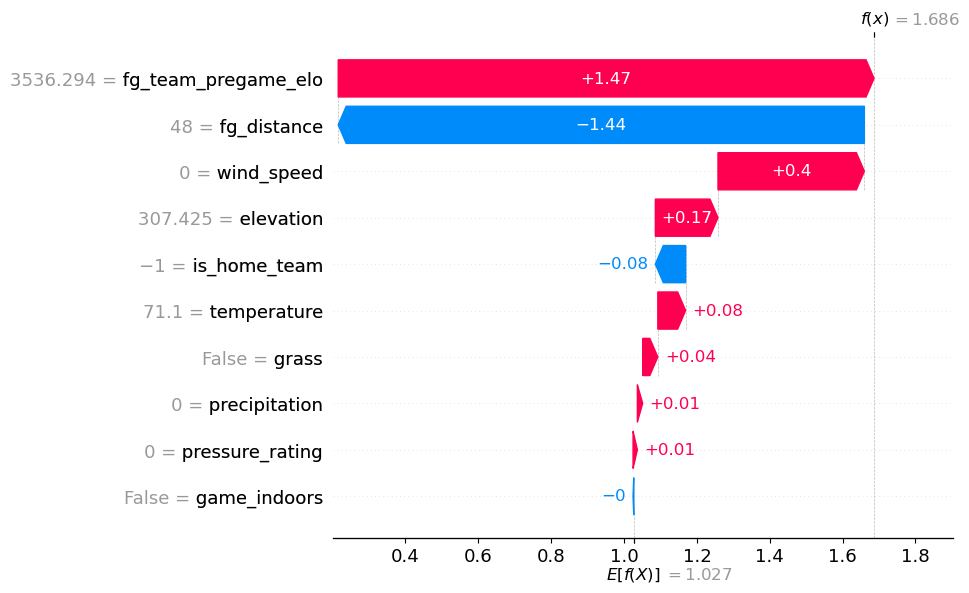

In [86]:
idx = 1104		

model = models[0]

game_data = data[data.index == idx].drop(columns=['game_id', 'fg_made']).head(1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

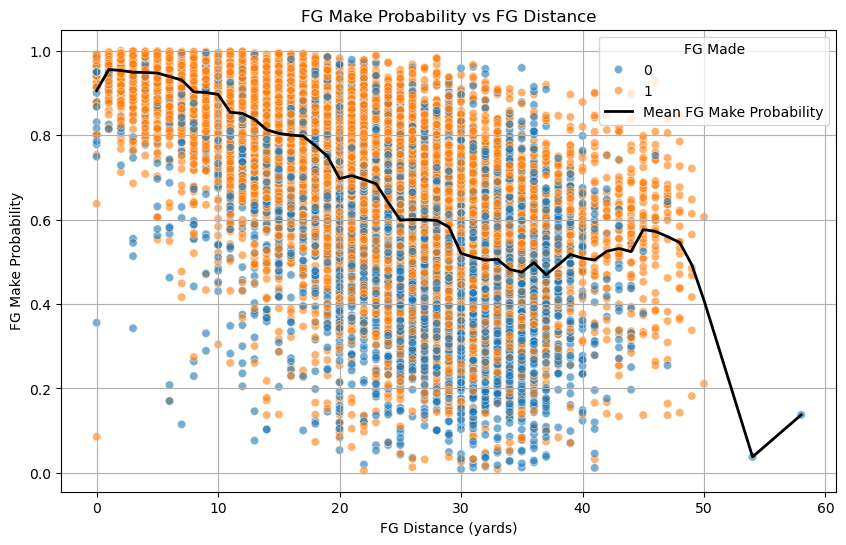

In [80]:
# plot fg_proba_50 vs fg_distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='fg_distance', y='fg_proba_50', hue='fg_made', alpha=0.6)
# plot the mean fg_proba_50 for each fg_distance
mean_fg_proba = df.groupby('fg_distance')['fg_proba_50'].mean().reset_index()
plt.plot(mean_fg_proba['fg_distance'], mean_fg_proba['fg_proba_50'], color='black', linewidth=2, label='Mean FG Make Probability')
plt.title('FG Make Probability vs FG Distance')
plt.xlabel('FG Distance (yards)')
plt.ylabel('FG Make Probability')
plt.grid()
plt.legend(title='FG Made', loc='upper right')
plt.show()

## 6. Save the models

In [81]:
model_dir = join(DATA_DIR, 'models', 'fg_probability')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i, model in enumerate(models):
    model_path = os.path.join(model_dir, f"model_{i}.json")
    model.save_model(model_path)

print(f"Saved {len(models)} models to the '{model_dir}' folder.")

Saved 100 models to the '../data/models/fg_probability' folder.
